In [41]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import pickle
import json
import shutil

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# datasets is a list of available datasets descriptions containing: path, key columns names, and suitable complex network features
from src.data.dataset_info import datasets


with_sort_timestamp = True


In [42]:
dataset = datasets[0]
name = dataset.name
print("dataset: {}".format(name))
# Chargement du fichier .parquet
df = pd.read_parquet('datasets/original/cic_ids_2017.parquet')

dataset: client_0


In [43]:
# converting all infinity values into nan then dropping all records containing nan values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

df.drop_duplicates(subset=list(set(df.columns) - set([dataset.timestamp_col, dataset.flow_id_col])), keep="first", inplace=True)

In [44]:
#dropping weak columns
if dataset.weak_columns:
    df = df[~df[dataset.class_col].isin(dataset.weak_columns)]

In [45]:
#sorting dataset based on timstamp
if with_sort_timestamp:
    df[dataset.timestamp_col] = pd.to_datetime(df[dataset.timestamp_col].astype(str).str.strip(), format=dataset.timestamp_format)
    df.sort_values(dataset.timestamp_col, inplace= True)

In [46]:
import json


In [48]:
#Attacks
classes_names = df[dataset.class_col].unique()
print(f"==>> classes: {classes_names}")

#encoding attacks 
label_encoder = LabelEncoder()
label_encoder.fit(list(classes_names))

df[dataset.class_num_col] = label_encoder.transform(df[dataset.class_col])
labels_names = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
# Convert numpy.int64 to native Python int for JSON serialization
labels_names_python = {int(k): str(v) for k, v in labels_names.items()}

# Save to JSON
with open('label_mappings.json', 'w') as f:
    json.dump({
        "classes": [str(c) for c in classes_names],  # Ensure all class names are strings
        "labels_names": labels_names_python
    }, f, indent=4)
print("Saved classes and labels_names to 'label_mappings.json'")

==>> classes: ['BENIGN' 'SSH-Patator' 'FTP-Patator' 'DoS slowloris' 'Heartbleed'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'PortScan' 'DDoS' 'Bot']
Saved classes and labels_names to 'label_mappings.json'


In [14]:
import pandas as pd

# Set to display ALL columns (temporary)
with pd.option_context('display.max_columns', None):  # None means unlimited
    print(df.head(10))

                                        Flow ID         Src IP  Src Port  \
193923                    8.0.6.4-8.6.0.1-0-0-0        8.6.0.1       0.0   
193119  192.168.10.25-23.194.182.12-59385-443-6  192.168.10.25   59385.0   
196820    192.168.10.1-192.168.10.3-53-61098-17   192.168.10.3   61098.0   
193120  192.168.10.25-23.194.182.12-59385-443-6  23.194.182.12     443.0   
489001  192.168.10.25-23.194.182.12-59385-443-6  192.168.10.25   59385.0   
427274   192.168.10.3-192.168.10.25-53-51147-17  192.168.10.25   51147.0   
355323  192.168.10.25-54.164.44.237-59264-443-6  192.168.10.25   59264.0   
193126  192.168.10.25-54.164.44.237-59264-443-6  54.164.44.237     443.0   
193275  192.168.10.25-54.164.44.237-59386-443-6  192.168.10.25   59386.0   
204865    192.168.10.1-192.168.10.3-53-60401-17   192.168.10.3   60401.0   

               Dst IP  Dst Port  Protocol           Timestamp  Flow Duration  \
193923        8.0.6.4       0.0       0.0 2017-03-07 01:00:01    118699862.0   
193

In [60]:
#afficher le nombre de classes descending to show imbalance
class_counts = df.groupby(dataset.class_col).size()

# Sort the counts in descending order
class_counts_sorted = class_counts.sort_values(ascending=False)
print(f"==>> class_counts_sorted: {class_counts_sorted}")


==>> class_counts_sorted: Attack
BENIGN                        2265910
DoS Hulk                       222563
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5769
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
dtype: int64


Blanacing dataset

In [61]:
df1 = pd.read_parquet('datasets/partitions/test.parquet')
#afficher le nombre de classes descending to show imbalance
class_counts = df1.groupby(dataset.class_col).size()

# Sort the counts in descending order
class_counts_sorted = class_counts.sort_values(ascending=False)
print(f"==>> class_counts_sorted: {class_counts_sorted}")


==>> class_counts_sorted: Attack
BENIGN                        226591
DoS Hulk                       22256
PortScan                       15880
DDoS                           12803
DoS GoldenEye                   1029
FTP-Patator                      793
SSH-Patator                      590
DoS slowloris                    577
DoS Slowhttptest                 550
Bot                              196
Web Attack � Brute Force         151
Web Attack � XSS                  65
Infiltration                       4
Web Attack � Sql Injection         2
Heartbleed                         1
dtype: int64


In [ ]:
#computing class weights to avoid undersampling/oversampling

In [62]:
#split the main dataset into train, test 
train, test = train_test_split(df, test_size=0.1, shuffle= True, random_state=1, stratify=df[dataset.class_col])


In [63]:
#save test dataset .parquet
test.to_parquet("./datasets/partitions/test.parquet")


In [64]:
# Splitting the train dataset into clients based on "Attack" column
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create directory for partitions
output_dir = "datasets/partitions/"
os.makedirs(output_dir, exist_ok=True)

# Dirichlet partitioning based on "Attack"
attack_types = train["Attack"].unique()
print(attack_types)
num_partitions = 10
partitions = [[] for _ in range(num_partitions)]

# Revised partitioning logic
for attack in attack_types:
    attack_data = train[train["Attack"] == attack].index
    if len(attack_data) > 0:
        # Generate random proportions (Dirichlet)
        proportions = np.random.dirichlet(0.5*np.ones(num_partitions))
        
        # Calculate split points - FIXED LOGIC
        split_points = []
        current = 0
        for p in proportions[:-1]:
            current += p
            split_points.append(int(current * len(attack_data)))
        
        # Ensure we have valid splits
        split_points = [sp for sp in split_points if 0 < sp < len(attack_data)]
        split_points = sorted(set(split_points))  # Remove duplicates
        
        # Create splits
        splits = np.split(attack_data, split_points) if split_points else [attack_data]
        
        for i, split in enumerate(splits):
            if i < num_partitions:
                partitions[i].extend(split)
print("Partitions created based on Attack types")

['BENIGN' 'DoS Hulk' 'DDoS' 'PortScan' 'DoS Slowhttptest' 'FTP-Patator'
 'DoS GoldenEye' 'DoS slowloris' 'Bot' 'SSH-Patator'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'Infiltration' 'Heartbleed']
Partitions created based on Attack types


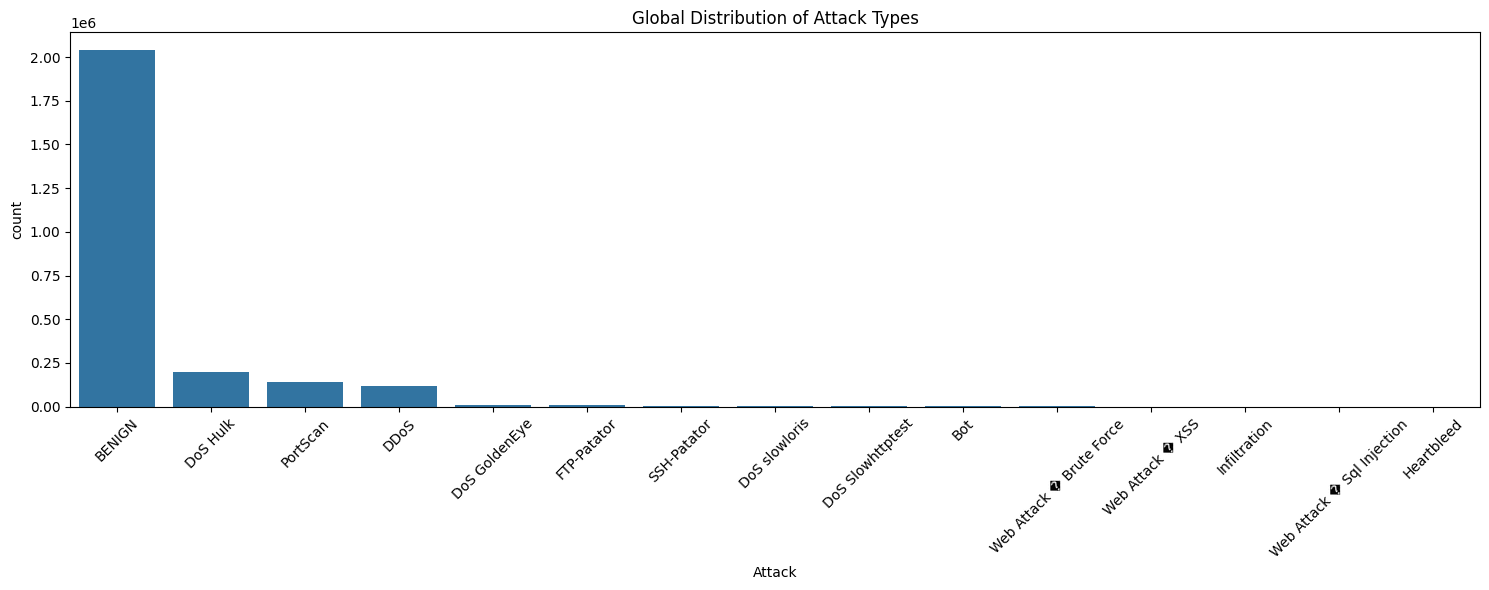

Partition 0 saved: datasets/partitions/client_0.parquet (1192874 samples)
Partition 1 saved: datasets/partitions/client_1.parquet (2052569 samples)
Partition 2 saved: datasets/partitions/client_2.parquet (2358077 samples)
Partition 3 saved: datasets/partitions/client_3.parquet (915717 samples)
Partition 4 saved: datasets/partitions/client_4.parquet (170000 samples)
Partition 5 saved: datasets/partitions/client_5.parquet (2985031 samples)
Partition 6 saved: datasets/partitions/client_6.parquet (614699 samples)
Partition 7 saved: datasets/partitions/client_7.parquet (892445 samples)
Partition 8 saved: datasets/partitions/client_8.parquet (1828995 samples)
Partition 9 saved: datasets/partitions/client_9.parquet (586449 samples)


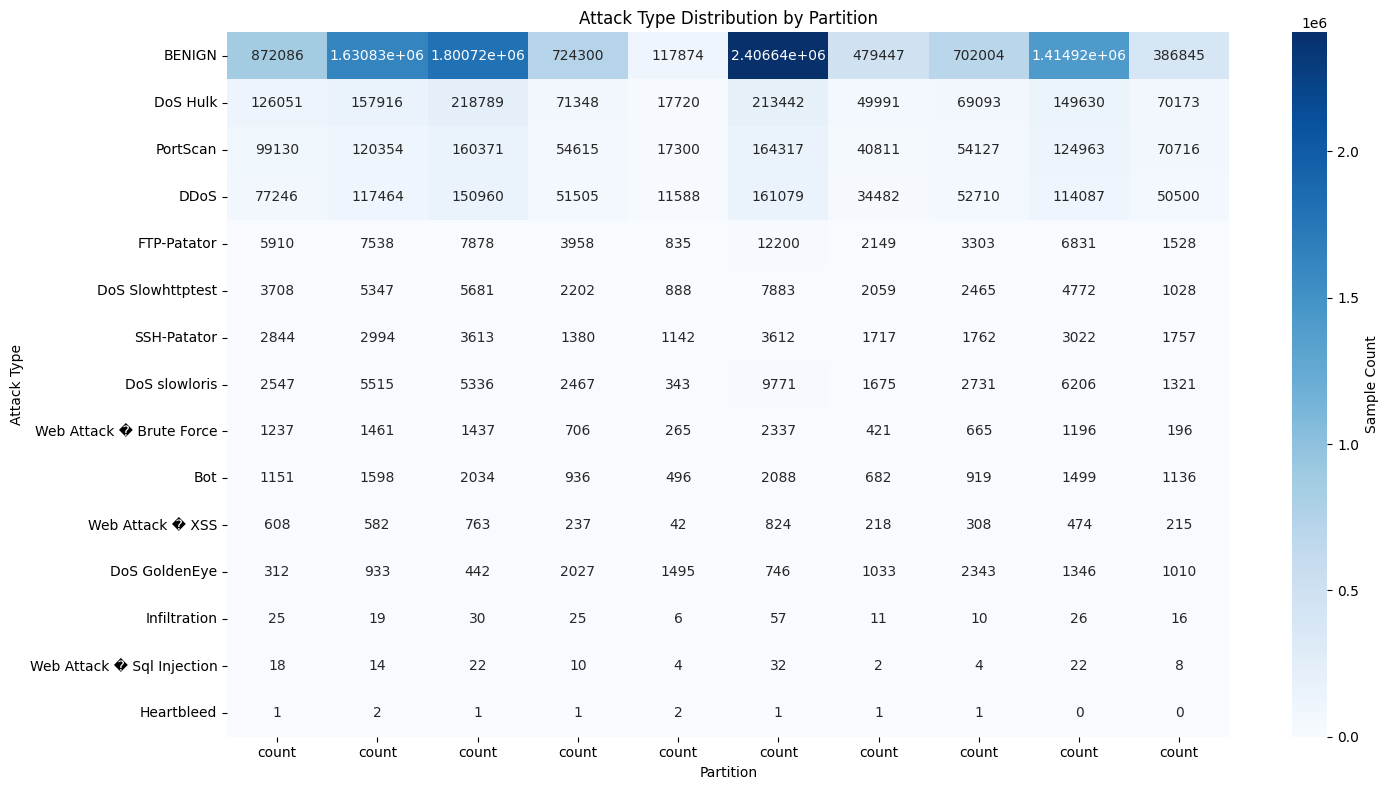

<Figure size 1500x800 with 0 Axes>

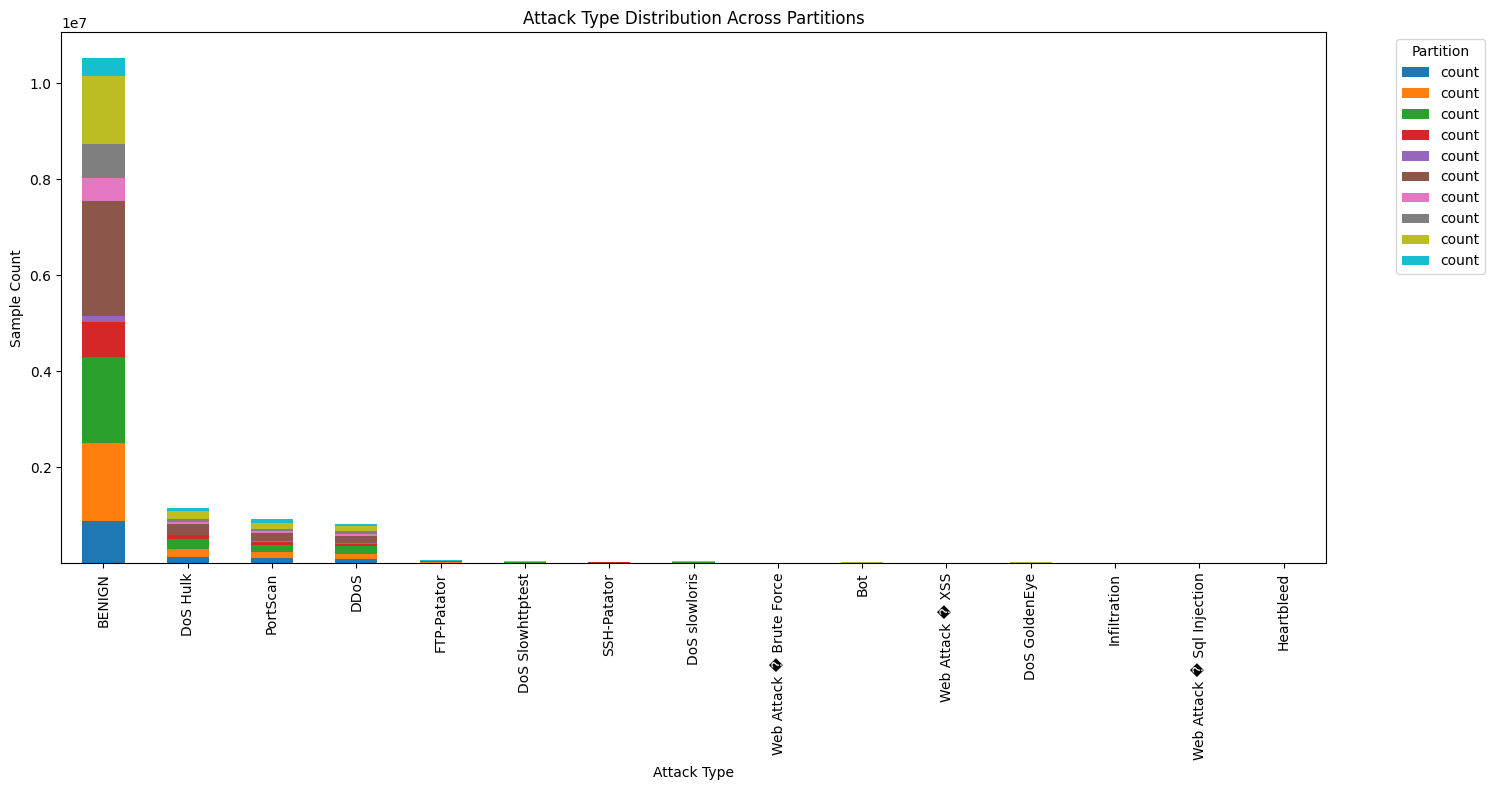

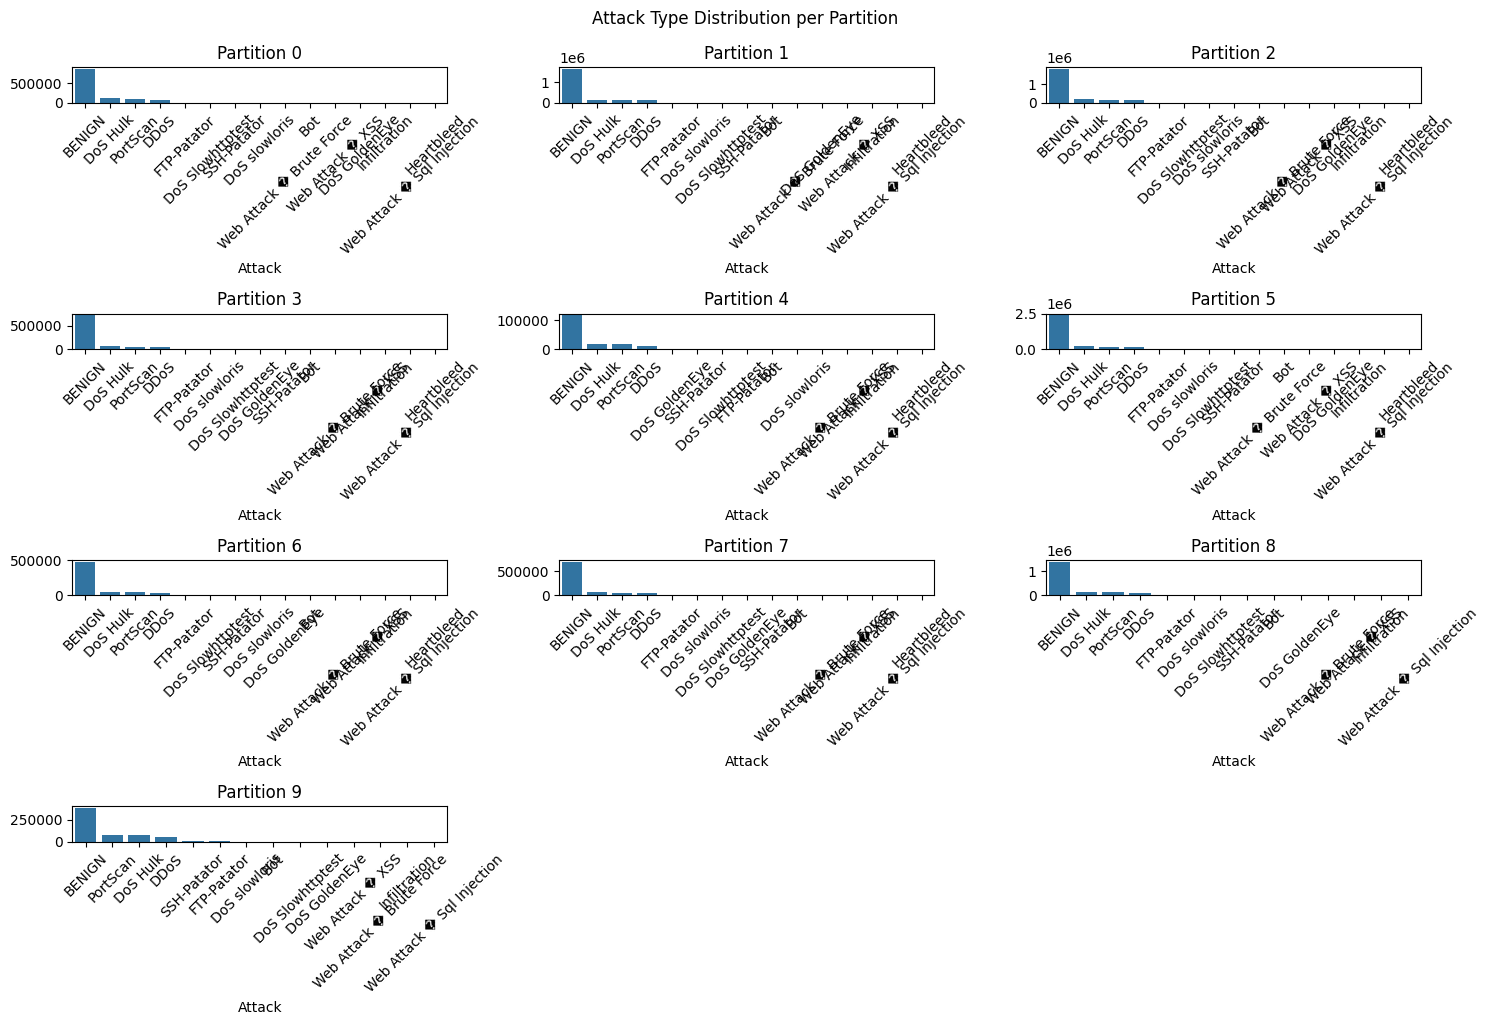


All partitions saved in: c:\Users\karayassamine\FL-GDLC\datasets\partitions
Visualizations saved in current directory


In [65]:
# VISUALIZATION OF DISTRIBUTIONS
# =====================================================================

# 1. Global distribution of attacks
plt.figure(figsize=(15, 6))
sns.countplot(data=train, x='Attack', order=train['Attack'].value_counts().index)
plt.title('Global Distribution of Attack Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('global_attack_distribution.png')
plt.show()

# 2. Distribution by partition
partition_data = []
for i, partition_indices in enumerate(partitions):
    if partition_indices:
        partition_df = train.loc[partition_indices]
        attack_counts = partition_df['Attack'].value_counts()
        partition_data.append(attack_counts)
        
        # Save partition
        file_path = os.path.join(output_dir, f"client_{i}.parquet")
        partition_df.to_parquet(file_path, index=False)
        print(f"Partition {i} saved: {file_path} ({len(partition_df)} samples)")
    else:
        print(f"Partition {i} is empty - not saved")
        partition_data.append(pd.Series(dtype=int))

# Create DataFrame for distributions
dist_df = pd.DataFrame(partition_data).fillna(0)
dist_df.index.name = 'Partition'

# Heatmap of distributions
plt.figure(figsize=(15, 8))
sns.heatmap(dist_df.T, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': "Sample Count"})
plt.title('Attack Type Distribution by Partition')
plt.xlabel('Partition')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.savefig('partition_attack_distribution_heatmap.png')
plt.show()

# Stacked bar chart
plt.figure(figsize=(15, 8))
dist_df.T.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Attack Type Distribution Across Partitions')
plt.xlabel('Attack Type')
plt.ylabel("Sample Count")
plt.legend(title='Partition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('partition_attack_stacked.png')
plt.show()

# Per-partition distribution plots
plt.figure(figsize=(15, 10))
for i, partition_counts in enumerate(partition_data):
    plt.subplot(4, 3, i+1)  # Adjust grid based on num_partitions
    sns.barplot(x=partition_counts.index, y=partition_counts.values)
    plt.title(f'Partition {i}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle('Attack Type Distribution per Partition', y=1.02)
plt.savefig('per_partition_attack_distribution.png')
plt.show()

print("\nAll partitions saved in:", os.path.abspath(output_dir))
print("Visualizations saved in current directory")

In [18]:
# DATA LOADING
def load_data(cid, file_path):
    dataset = datasets[cid]
    path = file_path
    df = pd.read_parquet(path)
    return df

In [67]:
for cid in range(10):
    print(f'***************Client{cid}****************')
    dataset = datasets[0]
    df = load_data(cid, f'./datasets/partitions/client_{cid}.parquet')
    #afficher le nombre de classes descending to show imbalance
    class_counts = df.groupby(dataset.class_col).size()
    
    # Sort the counts in descending order
    class_counts_sorted = class_counts.sort_values(ascending=False)
    print(f"==>> class_counts_sorted: {class_counts_sorted}")


***************Client0****************
==>> class_counts_sorted: Attack
BENIGN                        872086
DoS Hulk                      126051
PortScan                       99130
DDoS                           77246
FTP-Patator                     5910
DoS Slowhttptest                3708
SSH-Patator                     2844
DoS slowloris                   2547
Web Attack � Brute Force        1237
Bot                             1151
Web Attack � XSS                 608
DoS GoldenEye                    312
Infiltration                      25
Web Attack � Sql Injection        18
Heartbleed                         1
dtype: int64
***************Client1****************
==>> class_counts_sorted: Attack
BENIGN                        1630832
DoS Hulk                       157916
PortScan                       120354
DDoS                           117464
FTP-Patator                      7538
DoS slowloris                    5515
DoS Slowhttptest                 5347
SSH-Patator           

In [ ]:
#testing the function of calculating classes weights sur le dataset global
#y_local = df[dataset.class_col]
#compute_client_weights_multiclass(y_local)


Class Distribution:
  Class BENIGN: 2265910 samples (80.50%) | Weight: 0.0828
  Class Bot: 1956 samples (0.07%) | Weight: 95.9399
  Class DDoS: 128025 samples (4.55%) | Weight: 1.4658
  Class DoS GoldenEye: 10293 samples (0.37%) | Weight: 18.2317
  Class DoS Hulk: 222563 samples (7.91%) | Weight: 0.8432
  Class DoS Slowhttptest: 5499 samples (0.20%) | Weight: 34.1259
  Class DoS slowloris: 5769 samples (0.20%) | Weight: 32.5288
  Class FTP-Patator: 7935 samples (0.28%) | Weight: 23.6495
  Class Heartbleed: 11 samples (0.00%) | Weight: 17059.8667
  Class Infiltration: 36 samples (0.00%) | Weight: 5212.7370
  Class PortScan: 158804 samples (5.64%) | Weight: 1.1817
  Class SSH-Patator: 5897 samples (0.21%) | Weight: 31.8227
  Class Web Attack � Brute Force: 1507 samples (0.05%) | Weight: 124.5246
  Class Web Attack � Sql Injection: 21 samples (0.00%) | Weight: 8936.1206
  Class Web Attack � XSS: 652 samples (0.02%) | Weight: 287.8198

Weight Dictionary: {'BENIGN': np.float64(0.0828181760

{'BENIGN': np.float64(0.08281817606759903),
 'Bot': np.float64(95.93994546693934),
 'DDoS': np.float64(1.4657960033847557),
 'DoS GoldenEye': np.float64(18.231665533210272),
 'DoS Hulk': np.float64(0.8431703981943689),
 'DoS Slowhttptest': np.float64(34.1259380493423),
 'DoS slowloris': np.float64(32.528780262321604),
 'FTP-Patator': np.float64(23.649468599033817),
 'Heartbleed': np.float64(17059.866666666665),
 'Infiltration': np.float64(5212.737037037037),
 'PortScan': np.float64(1.1816990336095647),
 'SSH-Patator': np.float64(31.822712113504043),
 'Web Attack � Brute Force': np.float64(124.52457420924574),
 'Web Attack � Sql Injection': np.float64(8936.120634920635),
 'Web Attack � XSS': np.float64(287.819836400818)}

Adding centralities to clients and test

In [23]:
import networkx as nx
import igraph as ig
import json
import os
import pandas as pd
from collections import defaultdict

In [24]:
def define_communities(G):
    """Détecte les communautés dans le graphe en utilisant Infomap"""
    G1 = ig.Graph.from_networkx(G)
    print("Conversion vers igraph réussie")

    part = G1.community_infomap()
    print(f"Nombre de communautés détectées: {len(part)}")

    communities = []
    for com in part:
        node_names = [G1.vs[node_index]['_nx_name'] for node_index in com]
        communities.append(node_names)
       # print(f"Communauté {i}: {len(node_names)} nœuds")
        
    return communities, part

In [15]:
import networkx as nx
import igraph as ig
import json
import os
import pandas as pd
from collections import defaultdict

def calculate_graph_level_measures(df, dataset):
    G = nx.from_pandas_edgelist(
        df,
        source=dataset.src_ip_col,
        target=dataset.dst_ip_col,
        create_using=nx.DiGraph()
    )
    G.remove_nodes_from(list(nx.isolates(G)))

    print(f"===============")
    print(f"==>> number_of_nodes for graph {dataset.name}: {G.number_of_nodes()}")
    print(f"==>> number_of_edges for graph {dataset.name}: {G.number_of_edges()}")
    print(f"===============")
    # Initialisation des propriétés
    properties = {
        "client": dataset.name,
        "number_of_nodes": 0,
        "number_of_edges": 0,
        "max_degree": 0,
        "avg_degree": 0,
        "transitivity": 0,
        "density": 0,
        "mixing_parameter": 0,
        "modularity": 0,
        "communities": 0,
        "cn_measures" : [],
        "network_features": [],

    }
    
    # Vérification si le graphe est vide
    if len(G.nodes) == 0:
        print(f"Graphe vide pour {dataset.name}")
        return properties
    # Propriétés de base
    properties["number_of_nodes"] = G.number_of_nodes()
    properties["number_of_edges"] = G.number_of_edges()
    
    degrees = [degree for _, degree in G.degree()]
    properties["max_degree"] = max(degrees) if degrees else 0
    properties["avg_degree"] = sum(degrees) / len(degrees) if degrees else 0
    properties["transitivity"] = nx.transitivity(G)
    properties["density"] = nx.density(G)
    
    try:
        communities, part = define_communities(G)
        properties["communities"] = len(communities)
        

        # Calcul du mixing parameter
        node_to_community = {}
        for community_index, community in enumerate(communities):
            for node in community:
                node_to_community[node] = community_index
        
        inter_cluster_edges = 0
        for u, v in G.edges():
            if node_to_community.get(u, -1) != node_to_community.get(v, -1):
                inter_cluster_edges += 1
        
        properties["mixing_parameter"] = inter_cluster_edges / properties["number_of_edges"] if properties["number_of_edges"] > 0 else 0
        
        # Conversion des communautés pour networkx
        nx_communities = [set(com) for com in communities]
        properties["modularity"] = nx.community.modularity(G, nx_communities)
        
    except Exception as e:
        print(f"Erreur dans la détection des communautés pour {dataset.name}: {str(e)}")
    
    # Sauvegarde des résultats
    output_dir = './datasets_properties/'
    os.makedirs(output_dir, exist_ok=True)
    filename = f'{output_dir}/properties_{dataset.name}.json'

    with open(filename, 'w') as outfile:
        json.dump(properties, outfile, indent=4)
    
    return properties


In [31]:
import networkx as nx
import igraph as ig
import numpy as np
import json
import os
from src.network.network_features import separate_graph, cal_betweenness_centrality, cal_k_core, cal_k_truss
from src.network.CommCentralityCode import comm_centreality
from src.network.modularity_vitality import modularity_vitality
from src.data.dataset_info import (
        cn_measures_type_1,
        network_features_type_1, 
        cn_measures_type_2, 
        network_features_type_2,
        cn_measures_type_3,
        network_features_type_3, 
        cn_measures_type_4,
        network_features_type_4
    )



def calculate_node_level_measures(df, dataset):

    properties_path = f"./datasets_properties/properties_{dataset.name}.json" 
    #je dois reconstruire le graph G
    G = nx.from_pandas_edgelist(
    df,
    source=dataset.src_ip_col,
    target=dataset.dst_ip_col,
    create_using=nx.DiGraph()
    )
    G.remove_nodes_from(list(nx.isolates(G)))
    G1 = ig.Graph.from_networkx(G)


    #importer properties

    with open(properties_path, 'r') as f:
                properties = json.load(f)
 
    
    # Détection des communautés
    #je peux optimizer en gardant communities en var et l'appeller ici
    communities, part = define_communities(G)
    
    #Define thresholds
    density_threshold = 0.01
    transitivity_threshold = 0.1
    mixing_threshold = 0.1

    high_density = properties["density"] > density_threshold
    high_transitivity = properties["transitivity"] > transitivity_threshold
    high_mixing = properties["mixing_parameter"] > mixing_threshold

    if high_density and high_transitivity:
        if high_mixing:
            properties["cn_measures"] = cn_measures_type_3
            properties["network_features"] = network_features_type_3
            dataset.cn_measures = cn_measures_type_3
            dataset.network_features = network_features_type_3
            print("*************************Client{cid} network is of type 3")
        else:
            properties["cn_measures"] = cn_measures_type_4
            properties["network_features"] = network_features_type_4
            dataset.cn_measures = cn_measures_type_4
            dataset.network_features =network_features_type_4
            print("*************************Client{cid} network is of type 4")

    else:
        if high_mixing:
            properties["cn_measures"] = cn_measures_type_1
            properties["network_features"] = network_features_type_1
            dataset.cn_measures = cn_measures_type_1
            dataset.network_features = network_features_type_1
            print("*************************Client{cid} network is of type 1")

        else:
            properties["cn_measures"] = cn_measures_type_2
            properties["network_features"] = network_features_type_2
            dataset.cn_measures = cn_measures_type_2
            dataset.network_features = network_features_type_2
            print("*************************Client{cid} network is of type 2")

            
    with open(properties_path, 'w') as f:
        json.dump(properties, f, indent=4) 

    # Ajouter les attributs de communauté
    community_labels = {}
    for i, community in enumerate(communities):
        for node in community:
            community_labels[node] = i
    nx.set_node_attributes(G, community_labels, "new_community")
    
    # Séparer le graphe en parties intra/inter
    intra_graph, inter_graph = separate_graph(G, communities)
    print("separate graph done")
    
    # Dictionnaire pour stocker les mesures
    features_dicts = {}
    
    # Calculer les mesures de centralité
    if "betweenness" in dataset.cn_measures:
        nx.set_node_attributes(G, cal_betweenness_centrality(G), "betweenness")
        print(f"betweenness for {dataset.name}: is calculated ")
    if "local_betweenness" in dataset.cn_measures:
        nx.set_node_attributes(G, cal_betweenness_centrality(intra_graph), "local_betweenness")
        print(f"local_betweenness for {dataset.name}: is calculated ")

    if "global_betweenness" in dataset.cn_measures:
        nx.set_node_attributes(G, cal_betweenness_centrality(inter_graph), "global_betweenness")
        print(f"global_betweenness for {dataset.name}: is calculated ")

    
    if "degree" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.degree_centrality(G), "degree")
        print(f"degree for client {dataset.name}: is calculated ")

    if "local_degree" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.degree_centrality(intra_graph), "local_degree")
        print(f"local_degree for client {dataset.name}: is calculated ")

    if "global_degree" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.degree_centrality(inter_graph), "global_degree")
        print(f"global_degree for client {dataset.name}: is calculated ")

    
    if "eigenvector" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.eigenvector_centrality(G, max_iter=600), "eigenvector")
        print(f"eigenvector for client {dataset.name}: is calculated ")

    if "local_eigenvector" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.eigenvector_centrality(intra_graph, max_iter=600), "local_eigenvector")
        print(f"local_eigenvector for client {dataset.name}: is calculated ")

    if "global_eigenvector" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.eigenvector_centrality(inter_graph, max_iter=600), "global_eigenvector")
        print(f"global_eigenvector for client {dataset.name}: is calculated ")

    
    if "closeness" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.closeness_centrality(G), "closeness")
        print(f"closeness for client {dataset.name}: is calculated ")

    if "local_closeness" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.closeness_centrality(intra_graph), "local_closeness")
        print(f"local_closeness for client {dataset.name}: is calculated ")

    if "global_closeness" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.closeness_centrality(inter_graph), "global_closeness")
        print(f"global_closeness for client {dataset.name}: is calculated ")

    
    if "pagerank" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.pagerank(G, alpha=0.85), "pagerank")
        print(f"pagerank for client {dataset.name}: is calculated ")

    if "local_pagerank" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.pagerank(intra_graph, alpha=0.85), "local_pagerank")
        print(f"local_pagerank for client {dataset.name}: is calculated ")

    if "global_pagerank" in dataset.cn_measures:
        nx.set_node_attributes(G, nx.pagerank(inter_graph, alpha=0.85), "global_pagerank")
        print(f"global_pagerank for client {dataset.name}: is calculated ")

    
    if "k_core" in dataset.cn_measures:
        nx.set_node_attributes(G, cal_k_core(G), "k_core")
        print(f"k_core for client {dataset.name}: is calculated ")

    if "k_truss" in dataset.cn_measures:
        nx.set_node_attributes(G, cal_k_truss(G), "k_truss")
        print(f"k_truss for client {dataset.name}: is calculated ")

    if "Comm" in dataset.cn_measures:
        nx.set_node_attributes(G, comm_centreality(G, community_labels), "Comm")
        print(f"Comm for client {dataset.name}: is calculated ")

    if "mv" in dataset.cn_measures:
        nx.set_node_attributes(G, modularity_vitality(G1, part), "mv")
        print(f"mv for client {dataset.name}: is calculated ")

    #sauvegarder le nouveau graphe
    graph_path = "./datasets/preprocessed/graph_{}.gexf".format(dataset.name)
    nx.write_gexf(G, graph_path)

    
    # Extraire les attributs dans un dictionnaire
    for measure in dataset.cn_measures:
        features_dicts[measure] = nx.get_node_attributes(G, measure)
    
    # Ajouter les caractéristiques au DataFrame
    for feature in dataset.network_features:
        if feature.startswith("src_"):
            base_measure = feature[4:]
            df[feature] = df[dataset.src_ip_col].map(features_dicts.get(base_measure, {})).fillna(-1)
        elif feature.startswith("dst_"):
            base_measure = feature[4:]
            df[feature] = df[dataset.dst_ip_col].map(features_dicts.get(base_measure, {})).fillna(-1)
    new_path = "./datasets/preprocessed/{}.pkl".format(dataset.name)
    pd.to_pickle(df, new_path)
    return df

    

In [32]:
#applying GDLC for both clients and test

for client_id in range(10):
    print (f"******************** CLient {client_id} ***************************")
    path = f"./datasets/partitions/client_{client_id}.parquet"

    dataset = datasets[client_id]
    df = load_data(client_id, path)
    #calculate_graph_level_measures(df, dataset)
    calculate_node_level_measures(df, dataset)

    

******************** CLient 0 ***************************
Conversion vers igraph réussie
Nombre de communautés détectées: 3
*************************Client{cid} network is of type 2
separate graph done
betweenness for client_0: is calculated 
global_betweenness for client_0: is calculated 
degree for client client_0: is calculated 
global_degree for client client_0: is calculated 
eigenvector for client client_0: is calculated 
closeness for client client_0: is calculated 
pagerank for client client_0: is calculated 
global_pagerank for client client_0: is calculated 
k_core for client client_0: is calculated 
k_truss for client client_0: is calculated 
mv for client client_0: is calculated 
******************** CLient 1 ***************************
Conversion vers igraph réussie
Nombre de communautés détectées: 3
*************************Client{cid} network is of type 2
separate graph done
betweenness for client_1: is calculated 
global_betweenness for client_1: is calculated 
degree f

In [29]:
test_path = f"./datasets/partitions/test.parquet"
dataset = datasets[10]
df = pd.read_parquet(test_path)
#calculate_graph_level_measures(df, dataset)
calculate_node_level_measures(df, dataset)



Conversion vers igraph réussie
Nombre de communautés détectées: 15
*************************Client{cid} network is of type 1
separate graph done
betweenness for test: is calculated 
local_betweenness for test: is calculated 
degree for client test: is calculated 
local_degree for client test: is calculated 
eigenvector for client test: is calculated 
closeness for client test: is calculated 
pagerank for client test: is calculated 
local_pagerank for client test: is calculated 
k_core for client test: is calculated 
k_truss for client test: is calculated 
Comm for client test: is calculated 


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,src_pagerank,dst_pagerank,src_local_pagerank,dst_local_pagerank,src_k_core,dst_k_core,src_k_truss,dst_k_truss,src_Comm,dst_Comm
index,,,,,,,,,,,,,,,,,,,,,
185287,172.16.0.1-192.168.10.50-64214-80-6,192.168.10.50,80.0,172.16.0.1,64214.0,6.0,2017-07-07 04:14:00,101676822.0,6.0,9.0,...,0.000517,0.000063,0.001190,0.000042,1.000000,0.521739,0.035685,0.006639,0.312812,0.008033
280665,192.168.10.3-192.168.10.17-53-65302-17,192.168.10.17,65302.0,192.168.10.3,53.0,17.0,2017-07-07 03:25:00,214.0,2.0,2.0,...,0.026099,0.000332,0.034413,0.001294,1.000000,1.000000,0.584232,0.023237,0.626392,0.240664
57033,192.168.10.3-192.168.10.15-53-54384-17,192.168.10.15,54384.0,192.168.10.3,53.0,17.0,2017-06-07 02:05:00,23841.0,2.0,2.0,...,0.034803,0.000332,0.041412,0.001294,1.000000,1.000000,1.000000,0.023237,0.613267,0.240664
119172,192.168.10.25-104.88.42.42-52912-443-6,104.88.42.42,443.0,192.168.10.25,52912.0,6.0,2017-06-07 03:06:00,56.0,1.0,1.0,...,0.000130,0.041010,0.000041,0.050989,0.739130,1.000000,0.009129,0.521992,0.000076,0.658840
109569,172.16.0.1-192.168.10.50-52300-80-6,172.16.0.1,52300.0,192.168.10.50,80.0,6.0,2017-05-07 10:44:00,2.0,2.0,0.0,...,0.000063,0.000517,0.000042,0.001190,0.521739,1.000000,0.006639,0.035685,0.008033,0.312812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131150,158.255.65.22-192.168.10.25-443-50551-6,192.168.10.25,50551.0,158.255.65.22,443.0,6.0,2017-06-07 11:41:00,3.0,2.0,0.0,...,0.041010,0.000130,0.050989,0.000041,1.000000,0.565217,0.521992,0.004149,0.658840,0.000121
596856,192.168.10.3-192.168.10.8-53-53924-17,192.168.10.8,53924.0,192.168.10.3,53.0,17.0,2017-05-07 01:51:00,172.0,2.0,2.0,...,0.032208,0.000332,0.037965,0.001294,1.000000,1.000000,1.000000,0.023237,0.677115,0.240664
134489,192.168.10.8-192.168.10.19-50746-1054-6,192.168.10.8,50746.0,192.168.10.19,1054.0,6.0,2017-06-07 03:12:00,100.0,2.0,2.0,...,0.032208,0.025445,0.037965,0.030373,1.000000,1.000000,1.000000,0.380913,0.677115,0.611431


In [69]:
import pandas as pd
import pickle
for cid in range(10):
    # Load the dataset from .pkl file
    with open(f'datasets/preprocessed/client_{cid}.pkl', 'rb') as f:  
        data = pickle.load(f)

    # Extract column info directly
    column_names = data.columns.tolist()
    num_features = len(column_names)


    # Print results
    print(f"*********************Client{cid}***********************")
    print("Column Names:", column_names)
    print("Number of Features:", num_features)

*********************Client0***********************
Column Names: ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg 

In [52]:
# Load the dataset from .pkl file
with open('datasets/preprocessed/test.pkl', 'rb') as f:  
    data = pickle.load(f)

# Extract column info directly
column_names = data.columns.tolist()
num_features = len(column_names)


# Print results
print(f"*********************Test***********************")
print("Column Names:", column_names)
print("Number of Features:", num_features)

*********************Test***********************
Column Names: ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Siz

In [15]:
test_path = f"./datasets/partitions/test.parquet"
dataset = datasets[10]
df = pd.read_parquet(test_path)

#afficher le nombre de classes descending to show imbalance
class_counts = df.groupby(dataset.class_col).size()

# Sort the counts in descending order
class_counts_sorted = class_counts.sort_values(ascending=False)
print(f"==>> class_counts_sorted: {class_counts_sorted}")

==>> class_counts_sorted: Attack
BENIGN                        226591
DoS Hulk                       22256
PortScan                       15880
DDoS                           12803
DoS GoldenEye                   1029
FTP-Patator                      793
SSH-Patator                      590
DoS slowloris                    577
DoS Slowhttptest                 550
Bot                              196
Web Attack � Brute Force         151
Web Attack � XSS                  65
Infiltration                       4
Web Attack � Sql Injection         2
Heartbleed                         1
dtype: int64


In [ ]:
import pickle
import pandas as pd
import numpy as np
import torch
import json

from autoencoder import build_autoencoder
from src.data.dataset_info import datasets

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for cid in range(10):
    # Load the dataset from .pkl file
    with open(f'datasets/preprocessed/client_{cid}.pkl', 'rb') as f:
        data = pickle.load(f)
        print(f'client {cid} loaded')
        
    dataset = datasets[cid]
    properties_path = f"./datasets_properties/properties_{dataset.name}.json"
    with open(properties_path, 'r') as f:
        properties = json.load(f)
    data_centralities = properties["network_features"]

    train_data = data[data_centralities]
    num_features = len(data_centralities)
    print(num_features)
    print('centralities extracted')

    if num_features == 22:
        print('🔧 Client is Type 1/2 (22 features)')
        # Build and train autoencoder
        ae, optimizer, loss_fn = build_autoencoder(input_dim=22, latent_dim=14)
        ae = ae.to(DEVICE)

        X = torch.tensor(train_data.values, dtype=torch.float32, device=DEVICE)
        num_epochs = 100
        batch_size = 16

        # Training loop
        for epoch in range(num_epochs):
            ae.train()
            permutation = torch.randperm(X.size()[0])
            losses = []
            for i in range(0, X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x = X[indices]
                optimizer.zero_grad()
                outputs = ae(batch_x)
                loss = loss_fn(outputs, batch_x)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            if epoch == num_epochs-1:
                print(f"📉 Final training loss: {np.mean(losses):.4f}")

        # Generate latent features
        ae.eval()
        with torch.no_grad():
            latent = ae.encode(X).cpu().numpy()

    elif num_features == 14:
        print('🔧 Client is Type 3/4 (14 features)')
        latent = train_data.values  # Identity: just copy input

    print("🔄 Generating latent features dataframe")
    latent_df = pd.DataFrame(
        latent,
        columns=[f"latent_{i}" for i in range(latent.shape[1])]
    )

    # Remove original features and add latent features
    data = data.drop(columns=dataset.network_features)
    unified_data = pd.concat([data, latent_df], axis=1)

    # Save unified dataframe
    save_path = f"datasets/unified/client_{cid}.parquet"
    unified_data.to_parquet(save_path)

    print(f"💾 Saved unified data to {save_path}")
    print(f"   Original features: {num_features} → Latent features: {latent.shape[1]}")
    print(f"   Final dataframe shape: {unified_data.shape}")


client 0 loaded
22
centralities extracted
🔧 Client is Type 1/2 (22 features)
📉 AE trained - final loss: 0.0000
🔄 Generating latent features dataframe
💾 Saved unified data to datasets/unified/client_0.parquet
   Original features: 22 → Latent features: 14
   Final dataframe shape: (1192874, 99)
client 1 loaded
22
centralities extracted
🔧 Client is Type 1/2 (22 features)
📉 AE trained - final loss: 0.0000
🔄 Generating latent features dataframe
💾 Saved unified data to datasets/unified/client_1.parquet
   Original features: 22 → Latent features: 14
   Final dataframe shape: (2052569, 99)
client 2 loaded
22
centralities extracted
🔧 Client is Type 1/2 (22 features)
📉 AE trained - final loss: 0.0000
🔄 Generating latent features dataframe
💾 Saved unified data to datasets/unified/client_2.parquet
   Original features: 22 → Latent features: 14
   Final dataframe shape: (2358077, 99)
client 3 loaded
22
centralities extracted
🔧 Client is Type 1/2 (22 features)
📉 AE trained - final loss: 0.0000
🔄 Ge

In [36]:
import pyarrow.parquet as pq

# Load the Parquet file or dataset
table = pq.read_table('datasets/unified/client_0.parquet')  # or pq.ParquetDataset('your_directory/').read()

# Display basic information
print(f"Number of samples: {table.num_rows}")
print(f"Number of columns: {table.num_columns}")
print("Column names:")
for col in table.column_names:
    print(f"- {col}")

Number of samples: 1192874
Number of columns: 99
Column names:
- Flow ID
- Src IP
- Src Port
- Dst IP
- Dst Port
- Protocol
- Timestamp
- Flow Duration
- Tot Fwd Pkts
- Tot Bwd Pkts
- TotLen Fwd Pkts
- TotLen Bwd Pkts
- Fwd Pkt Len Max
- Fwd Pkt Len Min
- Fwd Pkt Len Mean
- Fwd Pkt Len Std
- Bwd Pkt Len Max
- Bwd Pkt Len Min
- Bwd Pkt Len Mean
- Bwd Pkt Len Std
- Flow Byts/s
- Flow Pkts/s
- Flow IAT Mean
- Flow IAT Std
- Flow IAT Max
- Flow IAT Min
- Fwd IAT Tot
- Fwd IAT Mean
- Fwd IAT Max
- Fwd IAT Min
- Bwd IAT Tot
- Bwd IAT Mean
- Bwd IAT Std
- Bwd IAT Max
- Bwd IAT Min
- Fwd PSH Flags
- Bwd PSH Flags
- Fwd URG Flags
- Bwd URG Flags
- Fwd Header Len
- Bwd Header Len
- Fwd Pkts/s
- Bwd Pkts/s
- Pkt Len Min
- Pkt Len Max
- Pkt Len Mean
- Pkt Len Std
- Pkt Len Var
- FIN Flag Cnt
- SYN Flag Cnt
- RST Flag Cnt
- PSH Flag Cnt
- ACK Flag Cnt
- URG Flag Cnt
- CWE Flag Count
- ECE Flag Cnt
- Down/Up Ratio
- Pkt Size Avg
- Fwd Seg Size Avg
- Bwd Seg Size Avg
- Fwd Byts/b Avg
- Fwd Pkts/b Avg

Applying autoencoder on test

In [ ]:
# Load the dataset from .pkl file
with open(f'datasets/preprocessed/test.pkl', 'rb') as f:  
    data = pickle.load(f)
    print(f'test loaded')
dataset = datasets[10]
properties_path = f"./datasets_properties/properties_{dataset.name}.json" 
with open(properties_path, 'r') as f:
        properties = json.load(f)
data_centralities =properties["network_features"]
train_data = data[data_centralities]
num_features = len(data_centralities)
print(num_features)
print('centralities extracted')

if num_features == 22 :
    print('🔧 test is Type 1/2 (22 features)')
    
    # Build and train autoencoder
    ae, encoder = build_autoencoder(input_dim=22, latent_dim=14)
    ae.fit(
        train_data, train_data,
        epochs=100,
        batch_size=16,
        verbose=0
    )
    
    # Evaluate and generate latent features
    loss = ae.evaluate(train_data, train_data, verbose=0)
    print(f"📉 AE trained - final loss: {loss:.4f}")
    latent = encoder.predict(train_data, verbose=0)

elif num_features == 14 :
    print('🔧 test is Type 3/4 (14 features)')
    
    # Build identity autoencoder
    ae, encoder = build_autoencoder(input_dim=14, latent_dim=14)
    
    # Set identity weights
    identity_weights = [np.eye(14), np.zeros(14)]
    encoder.layers[1].set_weights(identity_weights)
    
    # Generate latent features (same as input)
    latent = encoder.predict(train_data, verbose=0)
print("🔄 Generating latent features dataframe")
latent_df = pd.DataFrame(
    latent,
    columns=[f"latent_{i}" for i in range(latent.shape[1])]
)

# Remove original features and add latent features
data = data.drop(columns=dataset.network_features)


test loaded
22
centralities extracted
🔧 test is Type 1/2 (22 features)
📉 AE trained - final loss: 0.0001
🔄 Generating latent features dataframe


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [40]:
data = data.reset_index(drop=True)          # Drops old index, creates new default one (0, 1, 2...)
latent_df = latent_df.reset_index(drop=True)
unified_data = pd.concat([data, latent_df], axis=1)

# Save unified dataframe
save_path = f"datasets/unified/test.parquet"
unified_data.to_parquet(save_path)

print(f"💾 Saved unified data to {save_path}")
print(f"   Original features: {num_features} → Latent features: {latent.shape[1]}")
print(f"   Final dataframe shape: {unified_data.shape}")

💾 Saved unified data to datasets/unified/test.parquet
   Original features: 22 → Latent features: 14
   Final dataframe shape: (281488, 99)
